In [46]:
import socket
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import AESGCM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


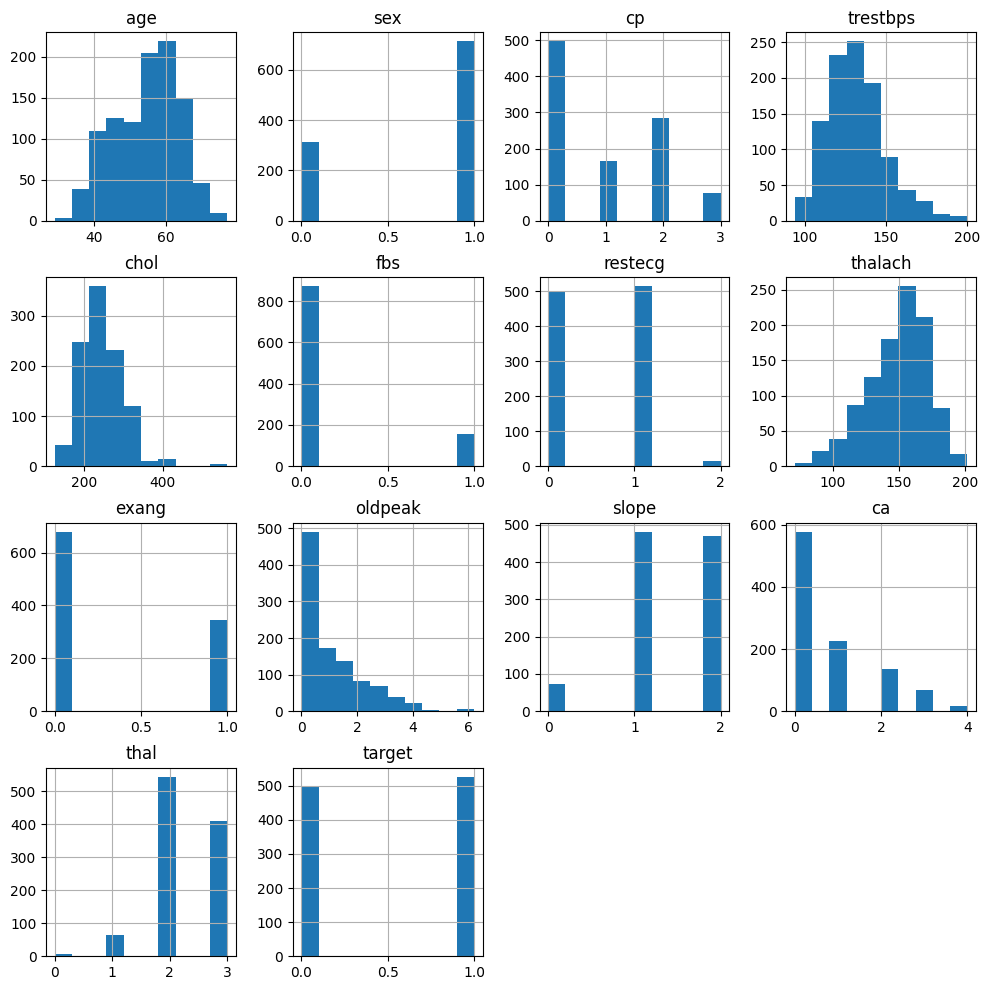

In [47]:
dataset_path = 'heart1ex.csv'
data = pd.read_csv(dataset_path)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
data.hist(figsize=(12,12))
plt.show()

In [48]:
data.describe()

age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000     0.000000     0.000000   
25%       0.000000     0.000000   132.000000     0.000000     0.000000   
50%       0.000000     1.000000   152.000000     0.000000     0.800000   
75%       0.000000     1.000000   166.000000     1.000000     1.800000   
max       1.000000     2.000000   202.000000     1.000000     6.200000   

             slope           ca         thal       target  
count  1025.000000  1025.000000  1025.000000  1025.000000  
mean      1.385366     0.754146     2.323902     0.513171  
std       0.617755     1.030798     0.620660     0.500070  
min       0.000000     0.000000     0.000000     0.000000  
25%       1.000000     0.000000     2.000000     0.000000  
50%       1.000000     0.000000     2.000000     1.000000  
75%       2.000000     1.000000     3.000000     1.000000  
max       2.000000     4.000000     3.000000     1.000000

In [49]:
def build_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(13,)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [50]:
server_ip = 'localhost'
server_port = 5000
client_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
client_socket.connect((server_ip, server_port))

In [51]:
client_private_key = ec.generate_private_key(ec.SECP256R1())
client_public_key = client_private_key.public_key()

In [52]:
server_public_key_pem = client_socket.recv(1024)
server_public_key = serialization.load_pem_public_key(server_public_key_pem)

In [53]:
client_socket.send(client_public_key.public_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PublicFormat.SubjectPublicKeyInfo
))

178

In [54]:
num_rounds = 200
for round_num in range(num_rounds):
    print(f"Starting round {round_num + 1}/{num_rounds}")
    
    encrypted_data = client_socket.recv(4096)
    shared_key = client_private_key.exchange(ec.ECDH(), server_public_key)
    derived_key = HKDF(algorithm=hashes.SHA256(), length=32, salt=None, info=b'handshake data').derive(shared_key)
    aesgcm = AESGCM(derived_key)
    nonce = b'\x00' * 12  
    data = aesgcm.decrypt(nonce, encrypted_data, None)
    global_weights = pickle.loads(data)
    
   
    model = build_model()
    if global_weights is not None:
        model.set_weights(global_weights)
    
    
    model.fit(X, y, epochs=1, verbose=0)
    
    
    local_weights = model.get_weights()
    data = pickle.dumps(local_weights)
    encrypted_data = aesgcm.encrypt(nonce, data, None)
    

    client_socket.send(encrypted_data)
    
    print(f"Round {round_num + 1} complete.")


client_socket.close()

print("Federated learning complete and connection closed.")


Starting round 1/200


c:\Users\krish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Round 1 complete.
Starting round 2/200
Round 2 complete.
Starting round 3/200
Round 3 complete.
Starting round 4/200
Round 4 complete.
Starting round 5/200
Round 5 complete.
Starting round 6/200
Round 6 complete.
Starting round 7/200
Round 7 complete.
Starting round 8/200
Round 8 complete.
Starting round 9/200
Round 9 complete.
Starting round 10/200
Round 10 complete.
Starting round 11/200
Round 11 complete.
Starting round 12/200
Round 12 complete.
Starting round 13/200
Round 13 complete.
Starting round 14/200
Round 14 complete.
Starting round 15/200
Round 15 complete.
Starting round 16/200
Round 16 complete.
Starting round 17/200
Round 17 complete.
Starting round 18/200
Round 18 complete.
Starting round 19/200
Round 19 complete.
Starting round 20/200
Round 20 complete.
Starting round 21/200
Round 21 complete.
Starting round 22/200
Round 22 complete.
Starting round 23/200
Round 23 complete.
Starting round 24/200
Round 24 complete.
Starting round 25/200
Round 25 complete.
Starting round